# Multi-Model Comparison - Code Comment Classification

This notebook compares multiple algorithms and selects the best performer.

## Steps:
1. Load encoded features
2. Define multiple models (Logistic Regression, SVC, SGD, Random Forest)
3. Train all models with cross-validation
4. Compare performance
5. Select and save best model

## Input Files:
- `train_features_4cat_bert_meta.npz`
- `test_features_4cat_bert_meta.npz`
- `train_target_4cat_meta.csv`
- `test_target_4cat_meta.csv`

## Output Files:
- `best_model_final.pkl` (saved trained model)

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Utilities
from scipy import sparse
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


## Load Encoded Features

In [2]:
# Load Features (Sparse Matrices)
X_train_model = sparse.load_npz("outputs/train_features_4cat_bert_meta.npz")
X_test_model = sparse.load_npz("outputs/test_features_4cat_bert_meta.npz")

# Load Targets (CSVs)
y_train_model = pd.read_csv("outputs/train_target_4cat_meta.csv").values.ravel()
y_test_model = pd.read_csv("outputs/test_target_4cat_meta.csv").values.ravel()

print(f"Training Data: {X_train_model.shape}")
print(f"Test Data:     {X_test_model.shape}")

Training Data: (2249, 695)
Test Data:     (563, 695)


## 4.1 Define Multiple Models with Balancing
We define a dictionary of models. Each model is wrapped in an `ImbPipeline` containing the `RandomOverSampler`. This ensures fair comparison.

In [3]:
# Dictionary of pipelines
# Note: MultinomialNB removed because it requires non-negative features (BERT has negative values)
models = {
    "Logistic Regression": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    
    "SGD Classifier": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', SGDClassifier(loss='hinge', random_state=42))
    ]),
    
    "Linear SVC": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LinearSVC(random_state=42, dual='auto'))
    ]),
    
    "Random Forest": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

print(f"Defined {len(models)} models with balancing strategies.")
print("Note: MultinomialNB excluded (incompatible with BERT's negative values)")

Defined 4 models with balancing strategies.
Note: MultinomialNB excluded (incompatible with BERT's negative values)


## 4.2 Train and Compare Models
We loop through the models, performing Cross-Validation on the training set. We track `F1-Macro` because it is the most important metric for our imbalanced data.

In [4]:
results = []

print("Starting Model Evaluation...")

for name, pipeline_multi in models.items():
    print(f"Training {name}...")
    
    # Cross-Validation (Balancing happens automatically inside folds)
    cv_scores = cross_val_score(pipeline_multi, X_train_model, y_train_model, cv=5, scoring='f1_macro')
    
    results.append({
        "Model": name,
        "Mean F1-Macro": cv_scores.mean(),
        "Std Dev": cv_scores.std()
    })

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values(by="Mean F1-Macro", ascending=False)
print("\n=== MODEL COMPARISON RESULTS ===")
print(results_df)

Starting Model Evaluation...
Training Logistic Regression...
Training SGD Classifier...
Training Linear SVC...
Training Random Forest...

=== MODEL COMPARISON RESULTS ===
                 Model  Mean F1-Macro   Std Dev
0  Logistic Regression       0.670433  0.033483
2           Linear SVC       0.660782  0.033723
1       SGD Classifier       0.640565  0.033932
3        Random Forest       0.498435  0.017747


## 4.3 Visual Comparison of Model Performance
We visualize the **Mean F1-Macro scores** to identify the best model.
- We use `plt.barh` because we are plotting **summary statistics** (already calculated means) rather than raw data.
- The black lines (`xerr`) represent the **Standard Deviation**. A short line means the model is stable; a long line means the performance varies a lot between different data splits.

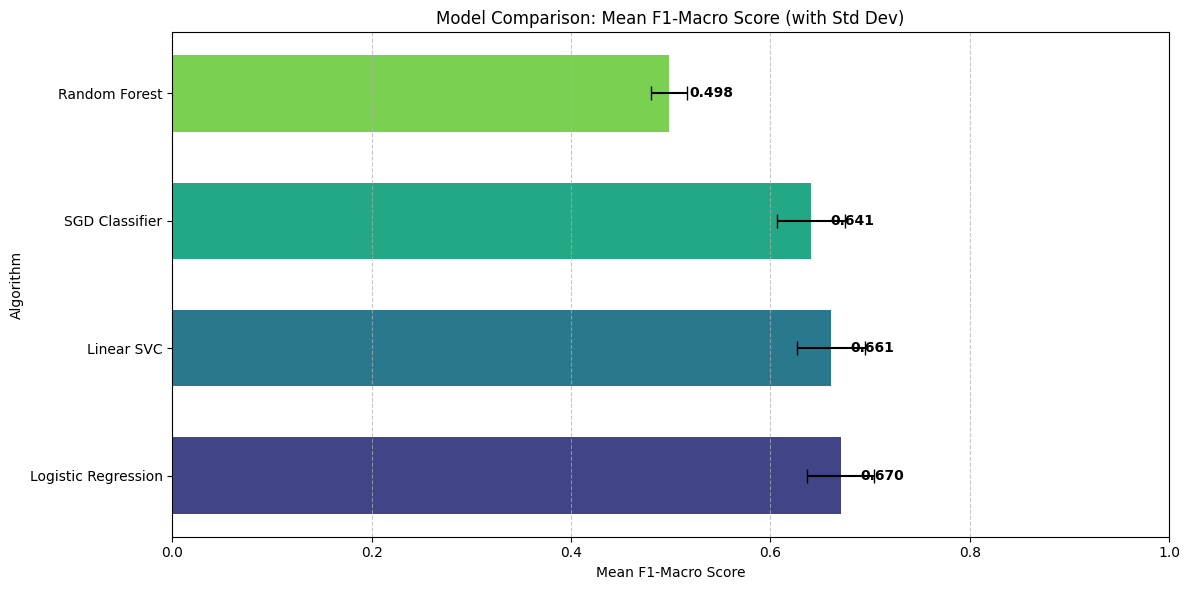

In [5]:
plt.figure(figsize=(12, 6))

# 1. Create a color palette
colors = sns.color_palette("viridis", len(results_df))

# 2. Plot Horizontal Bars
# We use 'barh' because it handles pre-calculated error bars (xerr) correctly
bars = plt.barh(
    y=results_df["Model"], 
    width=results_df["Mean F1-Macro"], 
    xerr=results_df["Std Dev"], 
    color=colors, 
    capsize=5,  # Adds the little cross-bar at the end of the error line
    height=0.6
)

plt.title("Model Comparison: Mean F1-Macro Score (with Std Dev)")
plt.xlabel("Mean F1-Macro Score")
plt.ylabel("Algorithm")
plt.xlim(0, 1.0) # F1 score is always between 0 and 1

# 3. Add numerical labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02,                      # x-position (slightly to the right of the bar)
        bar.get_y() + bar.get_height()/2,  # y-position (centered)
        f"{width:.3f}", 
        va='center', 
        fontweight='bold'
    )

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4.4 Final Evaluation on Locked Test Set
Cross-validation helped us select the winner. Now we must perform the **final test** on the held-out data that the model has never seen before.
1. **Select Winner:** We automatically pick the model at the top of our `results_df`.
2. **Retrain:** We fit this model on the entire training set to maximize learning.
3. **Predict:** We evaluate it on the locked Test Set.

  The Winning Model is: Logistic Regression
   (Mean CV F1-Score: 0.6704)

Retraining the best model on the full training dataset...
Retraining complete.

=== FINAL TEST SET PERFORMANCE ===
Accuracy: 0.6909

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       212
           1       0.51      0.56      0.54       101
           2       0.79      0.74      0.77       159
           3       0.60      0.66      0.63        91

    accuracy                           0.69       563
   macro avg       0.67      0.67      0.67       563
weighted avg       0.70      0.69      0.69       563



<Figure size 1000x800 with 0 Axes>

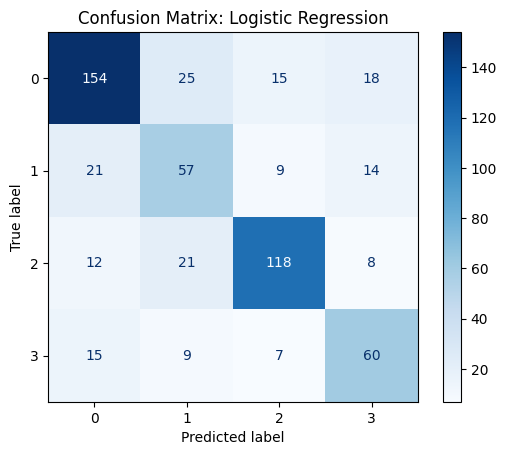

In [6]:
# 1. Identify the Best Model automatically
best_model_name = results_df.iloc[0]["Model"]
best_pipeline_final = models[best_model_name]

print(f"  The Winning Model is: {best_model_name}")
print(f"   (Mean CV F1-Score: {results_df.iloc[0]['Mean F1-Macro']:.4f})")

# 2. Retrain on the full training set
print("\nRetraining the best model on the full training dataset...")
best_pipeline_final.fit(X_train_model, y_train_model)
print("Retraining complete.")

# 3. Final Prediction on the Locked Test Set
y_pred_final = best_pipeline_final.predict(X_test_model)

# 4. Report Results
print("\n=== FINAL TEST SET PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_final):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_model, y_pred_final))

# 5. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_model, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

## 4.5 Save the Best Model
Finally, we serialize (save) the entire pipeline. This file includes the preprocessing steps (if any were added to the pipeline), the balancing strategy, and the trained classifier weights.

In [7]:
# Define a filename
filename = "outputs/best_model_final.pkl"

# Save the pipeline object
joblib.dump(best_pipeline_final, filename)

print(f"Model successfully saved to: {filename}")
print("You can load this model later using: model = joblib.load('best_model_final.pkl')")

Model successfully saved to: best_model_final.pkl
You can load this model later using: model = joblib.load('best_model_final.pkl')
